### Install `mmk` and its dependencies

In [ ]:
!git clone https://github.com/k-tonal/mmk.git
!pip install -r mmk/requirements.txt

### load the api token of your neptune account

In [ ]:
from getpass import getpass
api_token = getpass('Enter your private Neptune API token: ')

### Imports

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
import IPython.display as ipd
plt.rcParams['figure.figsize'] = (20, 6)
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

# model base class
from mmk.models.model_base import Model

# data utils
from mmk.data import Database

# debug, interact
from mmk.utils import show, audio, download_database, download_model, upload_model, numcpu, to_torch

### download some data and load it here

In [5]:
db_name = "gould.h5"
download_database(api_token, project_name="k-tonal/data", experiment_id="DAT-1", database_name=db_name)
db = Database(db_name)
db.metadata

start    stop  duration                                            name
0        0    4190      4190  gould/07 Invention 14 in B-flat major, BWV 785
1     4190   12541      8351         gould/26 Sinfonia 4 in D minor, BWV 790
2    12541   16485      3944         gould/16 Sinfonia 7 in E minor, BWV 793
3    16485   19451      2966   gould/08 Sinfonia 14 in B-flat major, BWV 800
4    19451   22971      3520   gould/05 Invention 5 in E-flat major, BWV 776
5    22971   25310      2339       gould/09 Invention 11 in G minor, BWV 782
6    25310   29202      3892        gould/01 Invention 1 in C major, BWV 772
7    29202   37210      8008    gould/06 Sinfonia 5 in E-flat major, BWV 791
8    37210   39439      2229       gould/13 Invention 15 in B minor, BWV 786
9    39439   46676      7237        gould/29 Invention 9 in F minor, BWV 780
10   46676   49092      2416       gould/21 Invention 12 in A major, BWV 783
11   49092   51668      2576        gould/23 Invention 3 in D major, BWV 774
12   51668   53395      1727       gould/11 Invention 10 in G major, BWV 781
13   53395   60360      6965        gould/17 Invention 6 in E major, BWV 777
14   60360   68179      7819         gould/04 Sinfonia 2 in C minor, BWV 788
15   68179   70911      2732        gould/27 Invention 8 in F major, BWV 779
16   70911   73038      2127         gould/18 Sinfonia 6 in E major, BWV 792
17   73038   84143     11105         gould/30 Sinfonia 9 in F minor, BWV 795
18   84143   86495      2352        gould/15 Invention 7 in E minor, BWV 778
19   86495   89728      3233        gould/22 Sinfonia 12 in A major, BWV 798
20   89728   91675      1947        gould/25 Invention 4 in D minor, BWV 775
21   91675   93648      1973         gould/02 Sinfonia 1 in C major, BWV 787
22   93648   96107      2459        gould/12 Sinfonia 10 in G major, BWV 796
23   96107   98039      1932       gould/19 Invention 13 in A minor, BWV 784
24   98039  100567      2528         gould/28 Sinfonia 8 in F major, BWV 794
25  100567  103423      2856         gould/24 Sinfonia 3 in D major, BWV 789
26  103423  113063      9640        gould/10 Sinfonia 11 in G minor, BWV 797
27  113063  115796      2733        gould/14 Sinfonia 15 in B minor, BWV 801
28  115796  123304      7508        gould/03 Invention 2 in C minor, BWV 773
29  123304  129087      5783        gould/20 Sinfonia 13 in A minor, BWV 799

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type   | Params
---------------------------------
0 | theta | Linear | 36 K  


initialized directory: rev-ae/linear/v0/



Training finished after 0 days 0 hours 0 mins 4 seconds


('final loss:', 22.599489212036133)

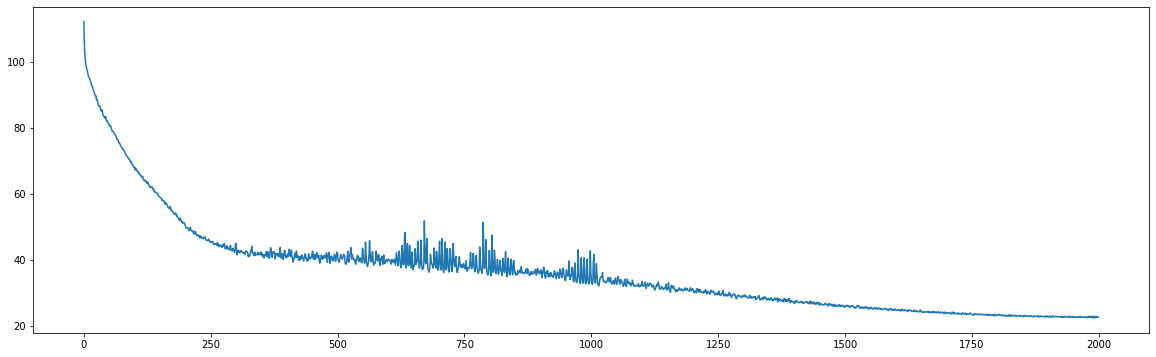

In [19]:
from mmk.data import load, Metadata

class ReversibleAutoencoder(Model):
    
    def __init__(self, **kwargs):
        super(ReversibleAutoencoder, self).__init__(**kwargs)
        
        input_dim = self.input_feature.dim
        self.theta = nn.Linear(input_dim, self.n_components, bias=self.use_bias)
        
        # helper function to permute T and D axis before and after the convolutions
#         self.permute = lambda x: x.transpose(1, 2)

    def latent_code(self, x):
        W = self.theta.weight
        B = self.theta.bias
            
        x = F.linear(x, W, B)
        return x
        
    def forward(self, x):
        W = self.theta.weight
        B = self.theta.bias
            
        x = F.linear(x, W, B)
        
        wwt = torch.matmul(W, W.t())
        indep_loss = self.indep_coeff * F.l1_loss(wwt,
                          torch.eye(wwt.size(0)).to(wwt))

        if self.enforce_abs:
            x = x.abs()
            
        x = F.linear(x, W.t()).abs()

        return x, indep_loss

    def training_step(self, batch, batch_idx):
        batch, target = batch
        output, indep_loss = self.forward(batch)
        recon = self.loss_fn(output, target)
        self.ep_losses += [recon.item()]
        L = recon + indep_loss
        return {"loss": L}
    
    def prepare_data(self):
        i, d = self.start_index, self.duration
        train_set = Metadata.from_start_stop([i], [i+d], [d])
        self.dl = load((self.input_feature, self.input_feature), train_set.copy(), "frame",
                       sequence_length=d, stride=1, shifts=(0, 0),
                       batch_size=1, shuffle=True,
                       pre_cat=True, device="cuda")
        
    def on_epoch_end(self):
        ep_loss = sum(self.ep_losses) / len(self.ep_losses)
        self.losses += [ep_loss]
        self.ep_losses = []
    
mdl = ReversibleAutoencoder(
    # data
    input_feature=db.fft,
    start_index=3000,
    duration=300,
    # model params
    n_components=36,
    use_bias=False,
    enforce_abs=False,
    indep_coeff=0.,
    # optim params
    max_lr=.0058,
    betas=(0.531, 0.531),
    max_epochs=2000,
    # file-system
    overwrite=True,
    name="linear",
    root_dir="rev-ae/",
    era_duration=3000,
             )
trainer = mdl.get_trainer()
trainer.fit(mdl)

plt.plot(mdl.losses)

"final loss:", mdl.losses[-1]

### Model's latents and predictions

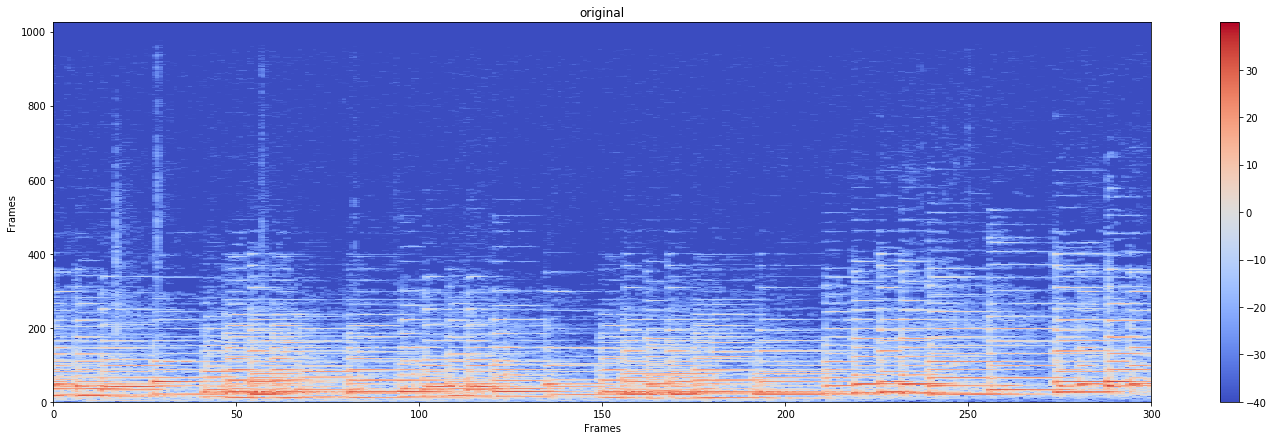

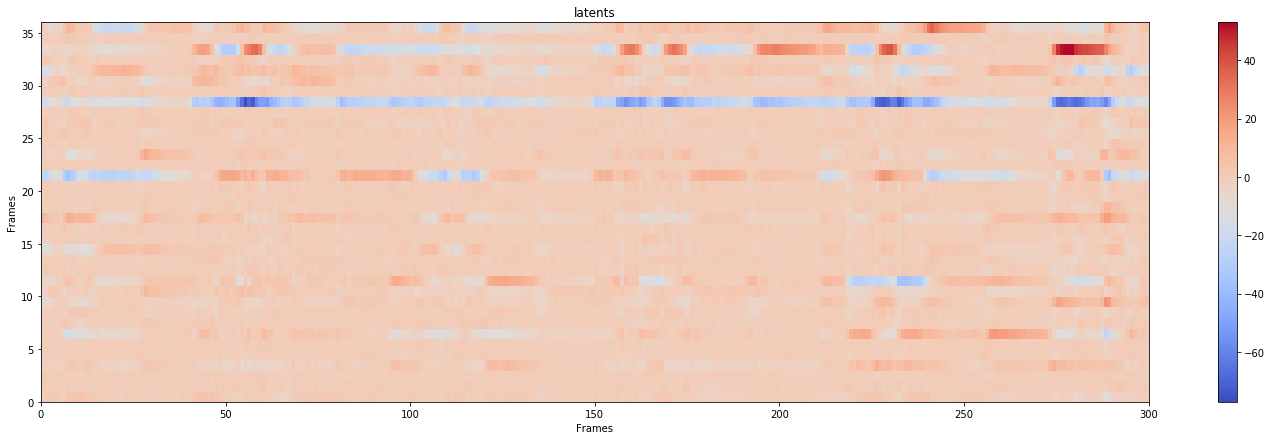

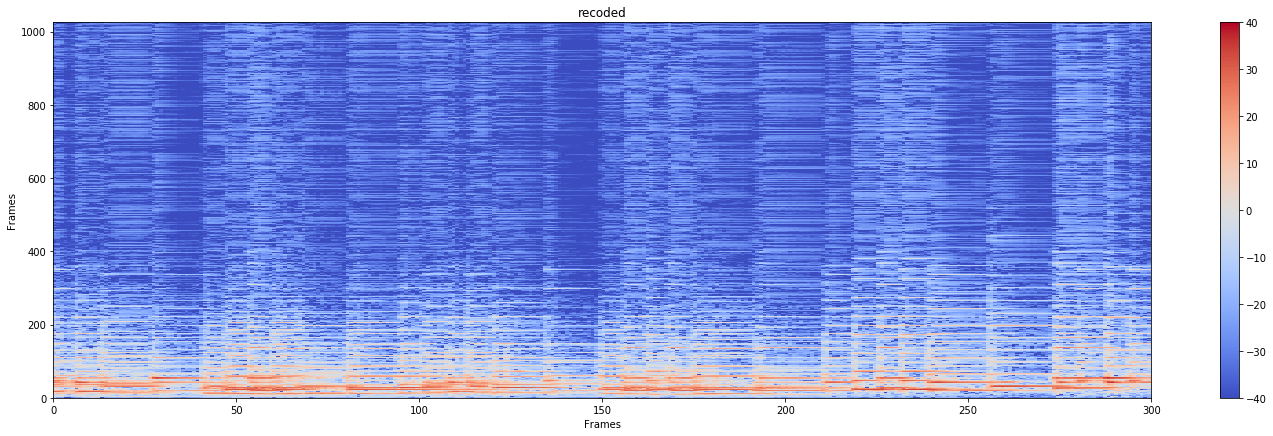

In [27]:
mdl = mdl.to("cuda")
x, _ = next(iter(mdl.dl))

with torch.no_grad():
    h = mdl.latent_code(x)
    y = mdl(x)
    
x = numcpu(x[0].squeeze()).T
plt.figure()
show(x, db_scale=True, title="original")
audio(x)

h = numcpu(h[0].squeeze()).T
plt.figure()
show(h, db_scale=False, title="latents")

y = numcpu(y[0].squeeze()).T
plt.figure()
show(y, title="re-coded")
audio(y)

### Model's Weights

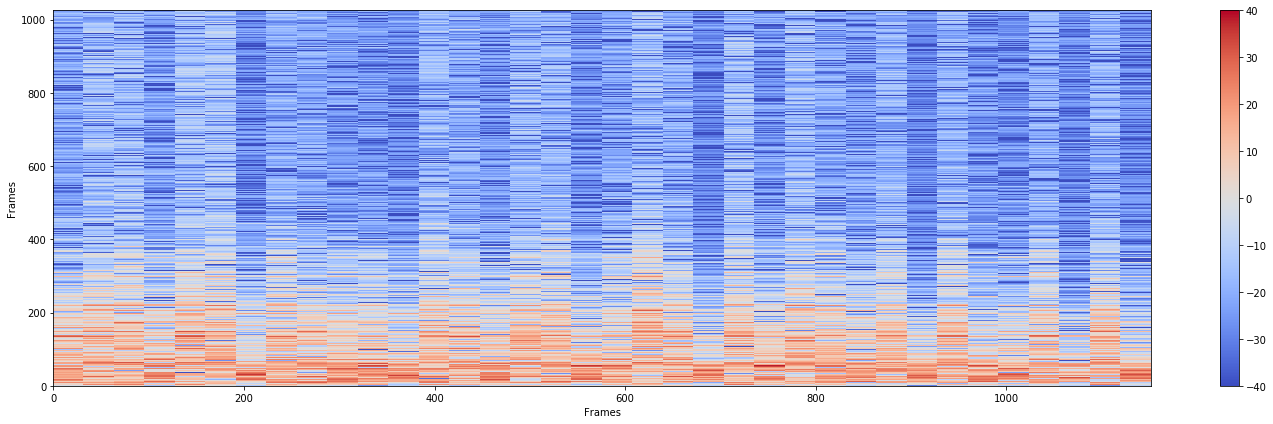

In [30]:
weights = numcpu(mdl.theta.weight.detach())
weights = np.stack(tuple(x for w in weights for x in [w]*32)).T

show(weights, db_scale=True)
audio(weights)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type   | Params
---------------------------------
0 | theta | Conv1d | 110 K 
/home/antoine/anaconda3/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:25: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


initialized directory: rev-ae/linear/v0/



Training finished after 0 days 0 hours 0 mins 4 seconds


('final loss:', 19.53455352783203)

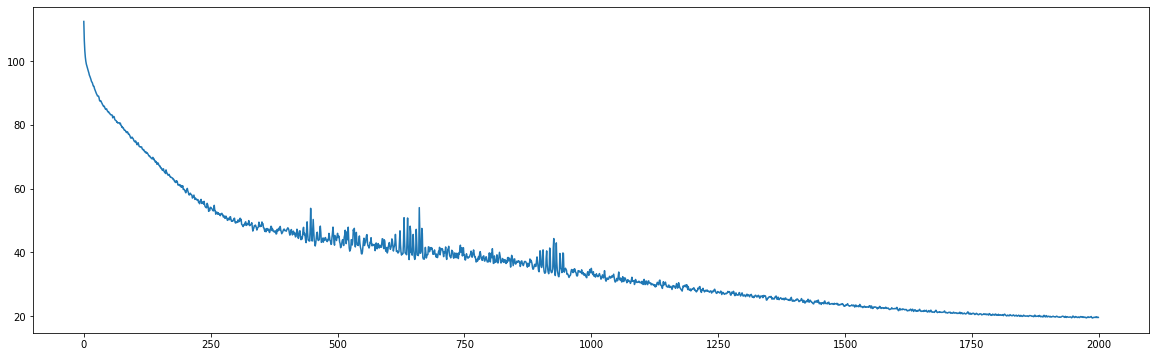

In [33]:

class ConvReversibleAutoencoder(Model):
    
    def __init__(self, **kwargs):
        super(ConvReversibleAutoencoder, self).__init__(**kwargs)
        
        input_dim = self.input_feature.dim
        self.theta = nn.Conv1d(input_dim, self.n_components, self.kernel_size, bias=self.use_bias)
        
        # helper function to permute T and D axis before and after the convolutions
        self.permute = lambda x: x.transpose(1, 2)

    def latent_code(self, x):
        W = self.theta.weight
        B = self.theta.bias
        x = self.permute(x)
        x = F.conv1d(x, W, B, padding=1)
        x = self.permute(x)
        return x
        
    def forward(self, x):
        W = self.theta.weight
        B = self.theta.bias
        
        x = self.permute(x)
        x = F.conv1d(x, W, B, padding=1)
        
        wwt = torch.matmul(W.sum(dim=2), W.sum(dim=2).t())
        indep_loss = self.indep_coeff * F.l1_loss(wwt,
                          torch.eye(wwt.size(0)).to(wwt))

        if self.enforce_abs:
            x = x.abs()
            
        x = F.conv_transpose1d(x, W, B, padding=1).abs()
        x = self.permute(x)

        return x, indep_loss

    def training_step(self, batch, batch_idx):
        batch, target = batch
        output, indep_loss = self.forward(batch)
        recon = self.loss_fn(output, target)
        self.ep_losses += [recon.item()]
        L = recon + indep_loss
        return {"loss": L}
    
    def prepare_data(self):
        i, d = self.start_index, self.duration
        train_set = Metadata.from_start_stop([i], [i+d], [d])
        self.dl = load((self.input_feature, self.input_feature), train_set.copy(), "frame",
                       sequence_length=d, stride=1, shifts=(0, 0),
                       batch_size=1, shuffle=True,
                       pre_cat=True, device="cuda")
        
    def on_epoch_end(self):
        ep_loss = sum(self.ep_losses) / len(self.ep_losses)
        self.losses += [ep_loss]
        self.ep_losses = []
    
mdl = ConvReversibleAutoencoder(
    # data
    input_feature=db.fft,
    start_index=3000,
    duration=300,
    # model params
    n_components=36,
    kernel_size=3,
    use_bias=False,
    enforce_abs=False,
    indep_coeff=0.,
    # optim params
    max_lr=.0018,
    betas=(0.531, 0.731),
    max_epochs=2000,
    # file-system
    overwrite=True,
    name="convolutional",
    root_dir="rev-ae/",
    era_duration=3000,
             )
trainer = mdl.get_trainer()
trainer.fit(mdl)

plt.plot(mdl.losses)

"final loss:", mdl.losses[-1]

### Model's latents and predictions

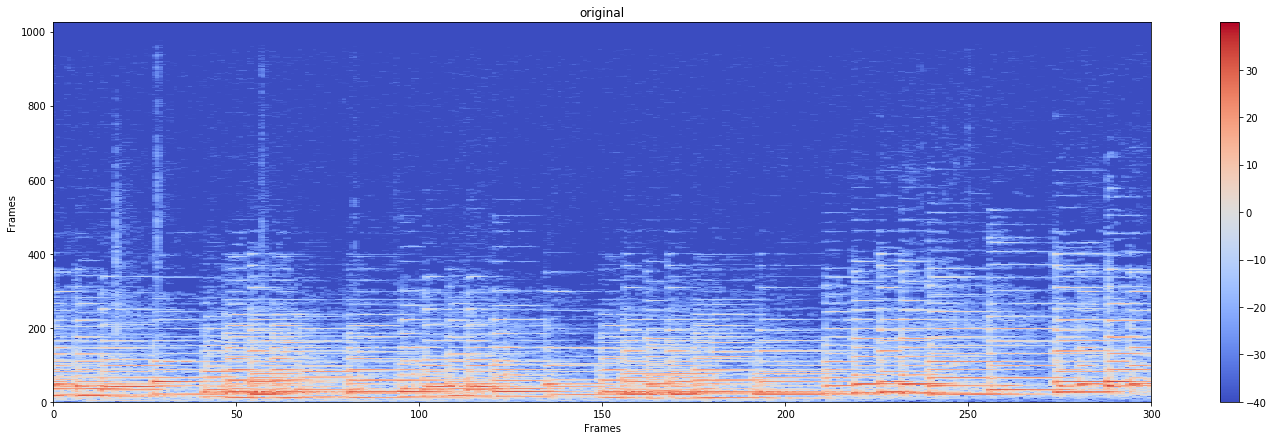

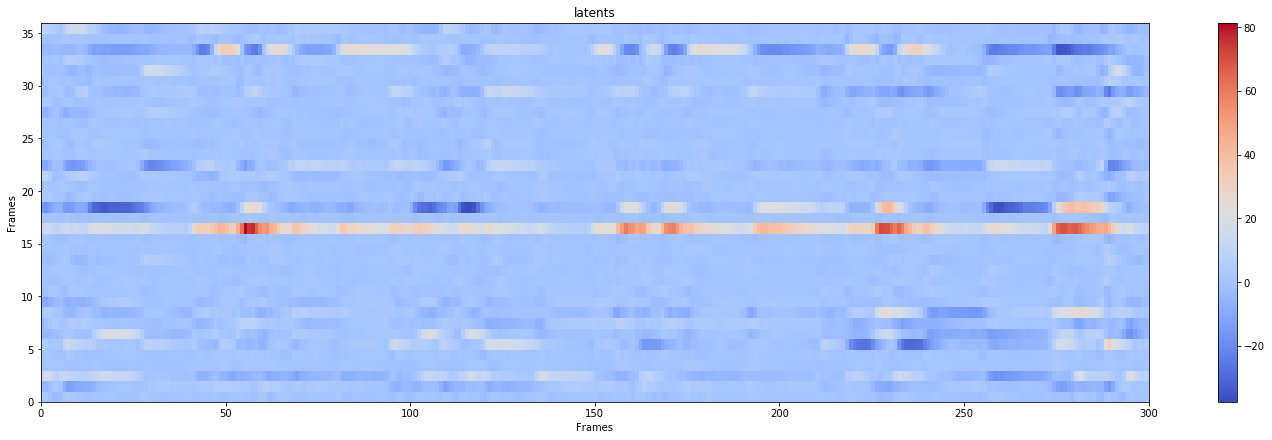

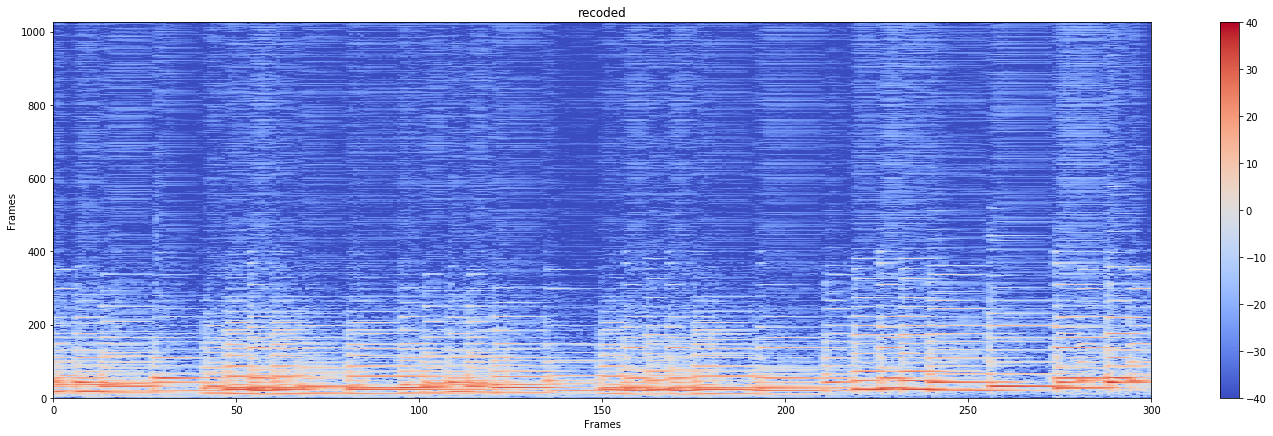

In [34]:
mdl = mdl.to("cuda")
x, _ = next(iter(mdl.dl))

with torch.no_grad():
    h = mdl.latent_code(x)
    y = mdl(x)
    
x = numcpu(x[0].squeeze()).T
plt.figure()
show(x, db_scale=True, title="original")
audio(x)

h = numcpu(h[0].squeeze()).T
plt.figure()
show(h, db_scale=False, title="latents")

y = numcpu(y[0].squeeze()).T
plt.figure()
show(y, title="re-coded")
audio(y)

### Model's Weights

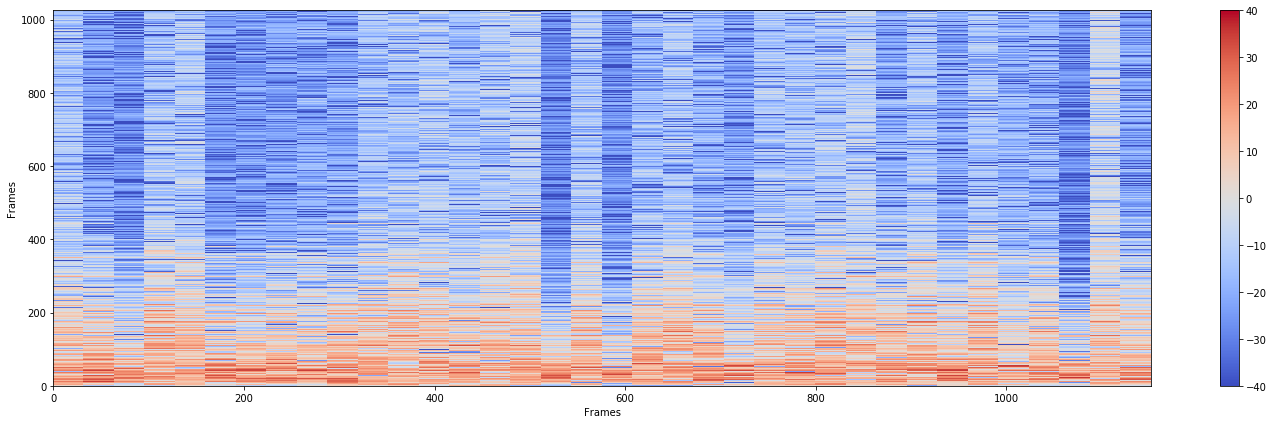

In [35]:
weights = numcpu(mdl.theta.weight.detach().sum(dim=2))
weights = np.stack(tuple(x for w in weights for x in [w]*32)).T

show(weights, db_scale=True)
audio(weights)

---

### upload your model to neptune

In [ ]:
upload_model(fnet, api_token, "k-tonal/model-upload-test")

### Either load a checkpoint ...

In [ ]:
root_dir="mmk_test_model/"
name="mmk_test_model"
version = str(0)
epoch = None

# load the checkpoint
fnet = ReversibleAutoencoder.load(FreqNet, root_dir + name + "/v" + version + "/", epoch)

### ... or download a model from neptune

In [ ]:
epoch = None
model_path  = download_model(api_token,
                             project_name="k-tonal/model-upload-test",
                             experiment_id="MOD-2")
fnet = ReversibleAutoencoder.load(FreqNet, model_path, epoch)